In [14]:
pip install ta

In [15]:
#Importing required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from ta.momentum import RSIIndicator
from tensorflow.keras import Input
import matplotlib.pyplot as plt

In [16]:
#Importing data and preprocessing.
#Setting random seeds for reproducibility.
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

#Importing Apple Stock prices dataset and converting date to datetime.
dfmv = pd.read_csv("AppleStockPrices.csv", index_col=None)
dfmv['Date'] = pd.to_datetime(dfmv['Date'])

#Making calculations for feature engineering.
dfmv['cubeRootVolume'] = np.cbrt(dfmv['Volume'])
rsiIndicator = RSIIndicator(dfmv['Close'], window=14)
dfmv['RSI'] = rsiIndicator.rsi()

#Filtering dataset to include only dates from 2008 onward.
post2007Df = dfmv[dfmv['Date'].dt.year >= 2008].copy()

#Defining features to be scaled.
featuresScaled = ['cubeRootVolume', 'RSI', 'Close']

#Conducting a time-based train test split for all time series data.
cutoffDate = '2018-01-01'
trainData = post2007Df[post2007Df['Date'] < cutoffDate]
testData = post2007Df[post2007Df['Date'] >= cutoffDate]

##Transforming data using MinMaxScaler, fitting to the training data only.
scaler = MinMaxScaler(feature_range=(0, 1))
trainScaled = trainData.copy()
testScaled = testData.copy()

trainScaled[featuresScaled] = scaler.fit_transform(trainData[featuresScaled])
testScaled[featuresScaled] = scaler.transform(testData[featuresScaled])

In [17]:
#LSTM specific processing.
#Creating the required sequences for LSTM.
daysInForecast1 = 3
features = ['cubeRootVolume', 'RSI', 'Close']
targetColumn = 'Close'

xTrain, yTrain = [], []
xTest, yTest = [], []

for i in range(daysInForecast1, len(trainScaled)):
    xTrain.append(trainScaled[features].iloc[i - daysInForecast1:i].values)
    yTrain.append(trainScaled[targetColumn].iloc[i])
xTrain, yTrain = np.array(xTrain), np.array(yTrain)

for i in range(daysInForecast1, len(testScaled)):
    xTest.append(testScaled[features].iloc[i - daysInForecast1:i].values)
    yTest.append(testScaled[targetColumn].iloc[i])
xTest, yTest = np.array(xTest), np.array(yTest)

#Splitting the data into training and validation sets.
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, shuffle=False)

In [18]:
#Building an LSTM Model with hyperparameter tuning and multiple layers.
def buildLSTMModel(units=20, dropoutRate=0.4, learningRate=0.01, l2Reg=0.001, numLayers=1, recurrentDropout=0.0, activation='tanh'):
    model = Sequential()
    model.add(Input(shape=(xTrain.shape[1], xTrain.shape[2])))
    model.add(LSTM(units=units, return_sequences=(numLayers > 1),
                   kernel_regularizer=l2(l2Reg), recurrent_dropout=recurrentDropout, activation=activation))
    model.add(Dropout(dropoutRate))
    if numLayers > 1:
        model.add(LSTM(units=units, kernel_regularizer=l2(l2Reg), recurrent_dropout=recurrentDropout, activation=activation))
        model.add(Dropout(dropoutRate))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learningRate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
    return model

In [19]:
#Establishing a baseline (or untuned) model for comparison.
#Defining baseline parameters for a baseline model.
baselineParams = {'units': 50,
                  'dropoutRate': 0.2,
                  'learningRate': 0.001,
                  'l2Reg': 0.0,
                  'numLayers': 1,
                  'recurrentDropout': 0.0,
                  'activation': 'tanh',}

#Defining a function to train and evaluate the LSTM model.
def trainAndEvaluate(params, epochs=50, batchSize=32):
    model = buildLSTMModel(**params)
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(xTrain, yTrain, epochs=epochs, batch_size=batchSize,
                        verbose=1, validation_data=(xVal, yVal), callbacks=[earlyStopping])
    valLoss = min(history.history['val_loss'])
    return model, valLoss

#Training the baseline model
baselineModel, baselineValLoss = trainAndEvaluate(baselineParams, epochs=50, batchSize=32)
print(f"Baseline Validation Loss: {baselineValLoss}")

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0597 - mae: 0.1912 - mse: 0.0597 - val_loss: 0.0368 - val_mae: 0.1772 - val_mse: 0.0368
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0065 - mae: 0.0627 - mse: 0.0065 - val_loss: 0.0021 - val_mae: 0.0409 - val_mse: 0.0021
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0020 - mae: 0.0344 - mse: 0.0020 - val_loss: 3.6764e-04 - val_mae: 0.0152 - val_mse: 3.6764e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mae: 0.0298 - mse: 0.0016 - val_loss: 5.2484e-04 - val_mae: 0.0182 - val_mse: 5.2484e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0014 - mae: 0.0278 - mse: 0.0014 - val_loss: 2.0911e-04 - val_mae: 0.0104 - val_mse: 2.0911e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - mae: 0.0252 - mse: 0.0011 - val_loss: 4.2316e-04 - val_mae: 0.0158 - val_mse: 4.2316e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - mae: 0.

In [20]:
#Testing parameters to find the best ones.
#Defining the winningest parameter grid.
paramGrid = {'units': [256],
             'dropoutRate': [0.1],
             'learningRate': [0.001],
             'l2Reg': [0.0],
             'numLayers': [1],
             'recurrentDropout': [0.0],
             'activation': ['linear', 'tanh'],}

#Tuning individual parameters defined above.
bestParams = baselineParams.copy()
bestValLoss = baselineValLoss
for paramName, paramValues in paramGrid.items():
    for value in paramValues:
        currentParams = bestParams.copy()
        currentParams[paramName] = value
        model, valLoss = trainAndEvaluate(currentParams, epochs=50, batchSize=32)
        #Checking the new models' performance and updating parameters if improved.
        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestParams[paramName] = value
            #print(f"New best for {paramName}: {value} with Val Loss: {valLoss}")
        #else:
            #print(f"No improvement for {paramName}: {value}")

print(f"Best parameters after individual tuning: {bestParams}")

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0339 - mae: 0.1299 - mse: 0.0339 - val_loss: 3.0324e-04 - val_mae: 0.0140 - val_mse: 3.0324e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.3048e-04 - mae: 0.0178 - mse: 5.3048e-04 - val_loss: 4.2179e-04 - val_mae: 0.0167 - val_mse: 4.2179e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.6990e-04 - mae: 0.0143 - mse: 3.6990e-04 - val_loss: 1.7480e-04 - val_mae: 0.0099 - val_mse: 1.7480e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4931e-04 - mae: 0.0140 - mse: 3.4931e-04 - val_loss: 1.5242e-04 - val_mae: 0.0090 - val_mse: 1.5242e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3247e-04 - mae: 0.0133 - mse: 3.3247e-04 - val_loss: 3.0205e-04 - val_mae: 0.0136 - val_mse: 3.0205e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.9939e-04 - mae: 0.0126 - mse: 2.9939e-04 - val_loss: 1.3759e-04 - val_mae: 0.0085 - val_mse: 1.3759e-04
Epoch 7/50
63/63 ━

In [21]:
#Training the final LSTM model with the best parameters from paramGrid in every section.
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(xTrain, yTrain, epochs=50, batch_size=32, verbose=3, validation_data=(xVal, yVal), callbacks=[earlyStopping])
finalModel = buildLSTMModel(**bestParams)
history = finalModel.fit(xTrain, yTrain, epochs=50, batch_size=32, verbose=3, validation_data=(xVal, yVal), callbacks=[earlyStopping])

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50


In [22]:
#Evaluating the final model on the test set
testForecast = finalModel.predict(xTest)
testForecast = scaler.inverse_transform(np.concatenate([np.zeros((testForecast.shape[0], len(featuresScaled) - 1)), testForecast], axis=1))[:, -1]
testActualPrice = scaler.inverse_transform(np.concatenate([np.zeros((yTest.shape[0], len(featuresScaled) - 1)), yTest.reshape(-1, 1)], axis=1))[:, -1]

#Evaluating the final model on the validation set
valForecast = finalModel.predict(xVal)
valForecast = scaler.inverse_transform(np.concatenate([np.zeros((valForecast.shape[0], len(featuresScaled) - 1)), valForecast], axis=1))[:, -1]
valActualPrice = scaler.inverse_transform(np.concatenate([np.zeros((yVal.shape[0], len(featuresScaled) - 1)), yVal.reshape(-1, 1)], axis=1))[:, -1]

#Calculating LSTM metrics on the test data
testMSE = mean_squared_error(testActualPrice, testForecast)
testRMSE = np.sqrt(testMSE)
testR2 = r2_score(testActualPrice, testForecast)

#Calculating LSTM metrics on the validation data
valMSE = mean_squared_error(valActualPrice, valForecast)
valRMSE = np.sqrt(valMSE)
valR2 = r2_score(valActualPrice, valForecast)

print("Model 2: Using Multiple Apple Variables to Predict Future Apple 'Close' Price")
print(f"Test MSE: {testMSE:<14}     | Test RMSE: {testRMSE:<13} | Test R^2: {testR2:<14}")
print(f"Val MSE: {valMSE:<14}     | Val RMSE: {valRMSE:<13}    | Val R^2: {valR2:<14}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model 2: Using Multiple Apple Variables to Predict Future Apple 'Close' Price
Test MSE: 5.4114527283036     | Test RMSE: 2.326252937301445 | Test R^2: 0.9958873823240617
Val MSE: 0.5663965500783863     | Val RMSE: 0.7525932168697684    | Val R^2: 0.9861050506982916


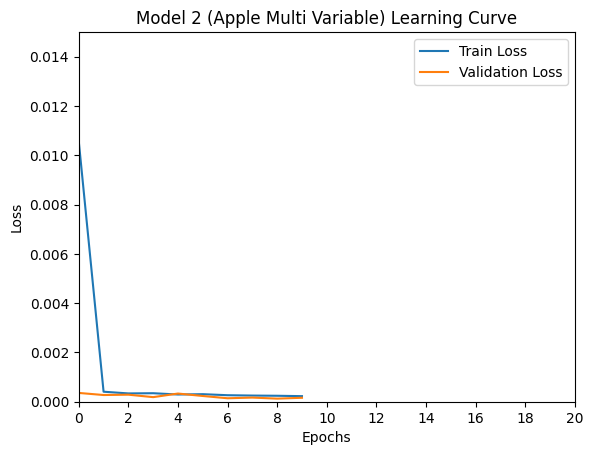

In [23]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model 2 (Apple Multi Variable) Learning Curve')
plt.ylim(0, 0.015)
plt.xticks(np.arange(0, 21, 2))
plt.xlim(0, 20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

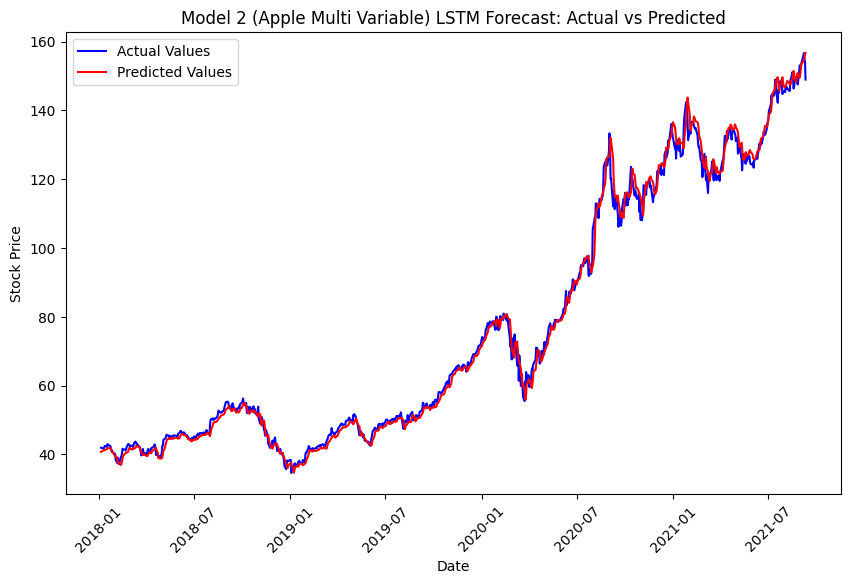

In [24]:
#Extracting the dates to properly format the x axis.
testDates = testData['Date'].iloc[daysInForecast1:].values

#Plotting actual vs predicted Apple Stock prices
plt.figure(figsize=(10, 6))
plt.plot(testDates, testActualPrice, label='Actual Values', color='blue')
plt.plot(testDates, testForecast, label='Predicted Values', color='red')
plt.title('Model 2 (Apple Multi Variable) LSTM Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()